### PACE Rapid Response Notebook - for workshopping workflow

To Do:
- adapt hackweek code to pull pace data for a given product, lat/lon extent, and time range defined before and after an event of interest
- spatially bin l2 data consistently?
- Make a mask of only pixels present both datasets (to prevent bias), compare data w/ pretty maps

In [1]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import cmocean
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from dask.distributed import Client
from matplotlib.patches import Rectangle
from PIL import Image, ImageEnhance

/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Development test-case
Hurricane Erin, look at chl-a before and after hurricane for
Timeline (using worldview): 
- Hurricane off florida/gulf stream PACE imagery on AUG 20
- AUG 21, hurricane passed and clear imagery
- Aug 18/19 hurricane not there yet

Lat/Lon bounds: 
UL: 32.09, -76.63 
LR: 27.78, -77.80


### Workflow
- use a datapoint in the center of AOI and time bounds/ earthaccess search to determine a granule form which we will define our L3M-like grid (see dask_gridding tutorial notebook)
- define crs, tramsform, shape from this L3M-like granule (chla_L3M_aoi in dask_griddding.ipynb notebook from hackweek)
- do another earthdata search, for full AOI over time period (1 week ish pre hurricane)
- open all and calculate average of parameter (in this case chl-a) using dask (follow dask_griddding.ipynb section 4)
- repeat above with timespan post hurricane, using same crs, tramsform, shape for gridding
- at this point, have pre and post hurricane chl averages on same spatial grid. now, mask each for pixels that have date pre and post hurricane
- make graphic showing before/after. Calculate average pre and post (using mask to avoid bias) and calculate a % increase in chl-a


In [38]:
# Newer workflow - test making the geographic parameter and dask steps functions

# all functions initilized here:

# Define Functions, don't modify
def grid_match(path, dst_crs, dst_shape, dst_transform, variable):
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
    da = dt["geophysical_data"][variable]
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})
    return da

def grid_match_SREF(path, dst_crs, dst_shape, dst_transform, variable):
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
    da = dt["geophysical_data"][variable]
    #da = da.assign_coords(wavelength_3d=dt["geophysical_data"]["wavelength"].values)
    da = da.transpose('wavelength_3d', 'number_of_lines', 'pixels_per_line')
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})

    # Regrid tilt to the new grid
    orig_lon = dt["navigation_data"]["longitude"].values
    orig_lat = dt["navigation_data"]["latitude"].values
    orig_tilt = dt["navigation_data"]["tilt"].values

    # Broadcast tilt to match the shape of longitude/latitude if needed
    if orig_tilt.ndim == 1 and orig_lon.shape != orig_tilt.shape:
        orig_tilt = np.broadcast_to(orig_tilt[:, None], orig_lon.shape)

    points = np.column_stack((orig_lon.ravel(), orig_lat.ravel()))
    values = orig_tilt.ravel()

    # Get the new grid from the reprojected DataArray
    new_lon = da["longitude"].values
    new_lat = da["latitude"].values

    # If new_lon/new_lat are 2D, flatten for griddata, then reshape after
    if new_lon.ndim == 2 and new_lat.ndim == 2:
        new_points = np.column_stack((new_lon.ravel(), new_lat.ravel()))
        tilt_regridded = griddata(points, values, new_points, method='nearest')
        tilt_regridded = tilt_regridded.reshape(new_lon.shape)
        da = da.assign_coords(tilt=(('latitude', 'longitude'), tilt_regridded))
    else:
        # If 1D, meshgrid and flatten
        lon_grid, lat_grid = np.meshgrid(new_lon, new_lat)
        new_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
        tilt_regridded = griddata(points, values, new_points, method='nearest')
        tilt_regridded = tilt_regridded.reshape(lon_grid.shape)
        da = da.assign_coords(tilt=(('latitude', 'longitude'), tilt_regridded))

    return da

def time_from_attr(ds):
    """Set the start time attribute as a dataset variable.
 
    Parameters
    ----------
    ds
        a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

def load_first(path, var):
    '''Load the first file returned in earthdata search, then manipulate to L3M-like, and
       store the crs, shape, and transform to make opening all the search result granules fast'''
    datatree = xr.open_datatree(path)
    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("longitude", "latitude"))

    var_data = dataset[var]# use code from dask_gridding notebook to transform L2 granule to L3M-like grid
    var_data = var_data.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    var_data = var_data.rio.write_crs("epsg:4326")
    var_L3M = var_data.rio.reproject(
        dst_crs="epsg:4326",
        src_geoloc_array=(
            var_data.coords["longitude"],
            var_data.coords["latitude"],
        ),
    )
    var_L3M = var_L3M.rename({"x":"longitude", "y":"latitude"})

    var_L3M_aoi = var_L3M.sel({"longitude": slice(bbox[0], bbox[2]),"latitude": slice(bbox[3], bbox[1])})

    crs = var_L3M_aoi.rio.crs# set mapping parameters from newly transformed file, to use when opening the rest with dask
    shape = var_L3M_aoi.rio.shape
    transform = var_L3M_aoi.rio.transform()

    return crs, shape, transform

def load_first_SREF(path, var):
    '''Load the first file returned in earthdata search, then manipulate to L3M-like, and
       store the crs, shape, and transform to make opening all the search result granules fast'''
    datatree = xr.open_datatree(path)
    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("longitude", "latitude"))
    print(dataset[var].coords)

    var_data = dataset[var]# use code from dask_gridding notebook to transform L2 granule to L3M-like grid
    var_data = var_data.transpose('wavelength_3d', 'number_of_lines', 'pixels_per_line')
    var_data = var_data.rio.set_spatial_dims("pixels_per_line", "number_of_lines")

    var_data = var_data.rio.write_crs("epsg:4326")
    var_L3M = var_data.rio.reproject(
        dst_crs="epsg:4326",
        src_geoloc_array=(
            var_data.coords["longitude"],
            var_data.coords["latitude"],
        ),
    )
    var_L3M = var_L3M.rename({"x":"longitude", "y":"latitude"})

    # Try to extend to bounding box
    var_L3M_aoi = var_L3M.rio.pad_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
        constant_values=np.nan
    )


    #var_L3M_aoi = var_L3M.sel({"longitude": slice(bbox[0], bbox[2]),"latitude": slice(bbox[3], bbox[1])})

    #print the minimum and maximum lognitude and latitude coords to check
    # print(var_L3M_aoi.longitude.min().values, var_L3M_aoi.longitude.max().values)
    # print(var_L3M_aoi.latitude.min().values, var_L3M_aoi.latitude.max().values)

    crs = var_L3M_aoi.rio.crs# set mapping parameters from newly transformed file, to use when opening the rest with dask
    shape = var_L3M_aoi.rio.shape 
    wl = var_L3M_aoi['wavelength_3d']
    transform = var_L3M_aoi.rio.transform()

    return crs, shape, transform, wl

def coregister_granules(paths, crs, shape, transform, var_name):
    ''' Use geographic parameters returned from load_first function to open all the granules for a given "paths" 
        Variable returned by earthdata search. returns an xarray dataset, where the time dimension differentiates
        data from each different granule
    
    '''

    client = Client()
    futures = client.map(grid_match,paths,dst_crs=crs,dst_shape=shape,dst_transform=transform, variable = var_name)
    kwargs = {"combine": "nested", "concat_dim": "time"}
    attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
    data = xr.combine_nested(client.gather(futures), concat_dim="time")# open all pre files. they are stored in same xarray dataset at different "time" coordinates 
    data["time"] = attrs["time"]
    client.close()
    print('loaded pre event files')

    return data

def coregister_granules_SREF(paths, crs, shape, transform, var_name):
    ''' Use geographic parameters returned from load_first function to open all the granules for a given "paths" 
        Variable returned by earthdata search. returns an xarray dataset, where the time dimension differentiates
        data from each different granule
    
    '''

    client = Client()
    futures = client.map(grid_match_SREF,paths,dst_crs=crs,dst_shape=shape,dst_transform=transform, variable = var_name)
    kwargs = {"combine": "nested", "concat_dim": "time"}
    attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
    data = xr.combine_nested(client.gather(futures), concat_dim="time")# open all pre files. they are stored in same xarray dataset at different "time" coordinates 
    data["time"] = attrs["time"]
    client.close()
    print('loaded pre event files')

    return data

def enhance(rgb, scale = 0.01, vmin = 0.01, vmax = 1.04, gamma=0.95, contrast=1.2, brightness=1.1, sharpness=2, saturation=1.1):
    """The SeaDAS recipe for RGB images from Ocean Color missions.

    Args:
        rgb: a data array with three dimensions, having 3 or 4 bands in the third dimension
        scale: scale value for the log transform
        vmin: minimum pixel value for the image
        vmax: maximum pixel value for the image
        gamma: exponential factor for gamma correction
        contrast: amount of pixel value differentiation 
        brightness: pixel values (intensity)
        sharpness: amount of detail
        saturation: color intensity

    Returns:
       a transformed data array better for RGB display
    """
    rgb = rgb.where(rgb > 0)
    rgb = np.log(rgb / scale) / np.log(1 / scale)
    rgb = rgb.where(rgb >= vmin, vmin)
    rgb = rgb.where(rgb <= vmax, vmax)    
    rgb_min = rgb.min(("latitude", "longitude"))
    rgb_max = rgb.max(("latitude", "longitude"))
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    rgb = rgb * gamma
    img = rgb * 255
    img = img.where(img.notnull(), 0).astype("uint8")
    img = Image.fromarray(img.data)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(sharpness)
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation)
    rgb[:] = np.array(img) / 255
    return rgb

def quick_plot_sref_1band(data_slice):
    """Quick plot function for a single band from SREF data
    """

    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
    plot = data_slice.sel(wavelength_3d=443, method='nearest').plot(
        x="longitude", y="latitude",
        cbar_kwargs={'label': 'rhos(443) [sr^-1]', 'shrink': 0.5},
        cmap=cmocean.cm.haline,
        norm=LogNorm(vmin=.001, vmax=0.1),
        ax=ax,
        robust=True
    )
    ax.set_xlim(bbox[0]-3, bbox[2]+3)
    ax.set_ylim(bbox[1]-3, bbox[3]+3)
    ax.coastlines()
    #ax.set_title(f'Granule {i+1} - Time: {str(data_slice.time.values)[:19]} - 443 nm')
    plt.show()


In [ ]:
# User definitions:

pre_tspan = ("2025-08-18", "2025-08-20")    # define your pre-event and post-event timespans
post_tspan = ("2025-08-21", "2025-08-22")
post_post_tspan = ("2025-08-24", "2025-08-28") # in case you want to look at a longer post-event period

min_lon = -82       # Set lat/lon extent for area of interest
min_lat = 25
max_lon = -63
max_lat = 33

# OCI suite and variable of interest within a particular suite
suite_name="PACE_OCI_L2_BGC_NRT" # shortname of the suite, e.g. For PACE: PACE_OCI_L2_BGC_NRT, PACE_OCI_L2_AOP_NRT, etc. (plan to add more to this comment)
var_name = "chlor_a" # variable of interest

in_the_cloud = False # set to true if running in cloud (e.g. Cryocloud), false if running locally. For speed, granules will be downloaded to a local_data directory when set to false

In [ ]:
# Perform the earthdata search:
bbox = (min_lon, min_lat, max_lon, max_lat)

pre_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=pre_tspan,
    bounding_box=bbox,
)
print(" Number of pre-event granules: "+str(len(pre_results)))

post_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=post_tspan,
    bounding_box=bbox,
)
print(" Number of post-event granules: "+str(len(post_results)))

post_post_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=post_post_tspan,
    bounding_box=bbox,
)
print(" Number of post-event granules: "+str(len(post_results)))

# if not in the cloud, make a folder to downlad granules to. This folder is configured in the .gitignore to not be tracked
if in_the_cloud == False:
    os.makedirs('local_data/', exist_ok=True)

# in running this script in the cloud, earthaccess.open is fast, but when running locally it takes a long time (10+ min), and locally downloading the data is faster.
# so, get the data with different approaches, depening on whether you are in the cloud or not, defined above
if in_the_cloud == True:
    pre_paths = earthaccess.open(pre_results)
    post_paths = earthaccess.open(post_results)
    post_post_path = earthaccess.open(post_post_results)
else:
    pre_paths = earthaccess.download(pre_results, local_path="local_data/")
    post_paths = earthaccess.download(post_results, local_path="local_data/")
    post_post_paths = earthaccess.download(post_post_results, local_path="local_data/")
    print('Files Downloaded')


In [ ]:
# extract the geospatial characteristics from the first file in paths using 1-line function
# This cell is steps is parts 1, 2a, and 2b from previous workflow. functions clean things up nicely

crs, shape, transform = load_first(pre_paths[0], var_name)# once set, dont need to rerun for other vars in same suite

pre_data = coregister_granules(pre_paths, crs, shape, transform, var_name)
post_data = coregister_granules(post_paths, crs, shape, transform, var_name)
post_post_data = coregister_granules(post_post_paths, crs, shape, transform, var_name)

In [ ]:
#fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig,ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_data.mean("time").plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[0], robust=True)
ax[0].set_xlim(bbox[0]-3,bbox[2]+3)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('Pre_hurricane Mean (8/15 - 8/20)')

ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_data.mean("time").plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[1], robust=True)
ax[1].set_xlim(bbox[0]-3,bbox[2]+3)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('Post Hurricane Mean (8/21 - 8/22)')

fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_post_data.mean("time").plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax, robust=True)
ax.set_xlim(bbox[0]-3,bbox[2]+3,)
ax.set_ylim(bbox[1]-3,bbox[3]+3)
ax.coastlines()
ax.set_title('~ 1 Week After Hurricane Mean (8/21 - 8/28)')

for i, data_slice in enumerate(pre_data):
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
    plot = data_slice.plot(
        x="longitude", y="latitude",
        cbar_kwargs={'label': 'Chlor mg/m3', 'shrink': 0.5},
        cmap=cmocean.cm.haline,
        norm=LogNorm(vmin=.01, vmax=5),
        ax=ax,
        robust=True
    )
    ax.set_xlim(bbox[0]-3, bbox[2]+3)
    ax.set_ylim(bbox[1]-3, bbox[3]+3)
    ax.coastlines()
    ax.set_title(f'Granule {i+1} - Time: {str(data_slice.time.values)[:19]}')
    plt.show()

for i, data_slice in enumerate(post_data):
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
    plot = data_slice.plot(
        x="longitude", y="latitude",
        cbar_kwargs={'label': 'Chlor mg/m3', 'shrink': 0.5},
        cmap=cmocean.cm.haline,
        norm=LogNorm(vmin=.01, vmax=5),
        ax=ax,
        robust=True
    )
    ax.set_xlim(bbox[0]-3, bbox[2]+3)
    ax.set_ylim(bbox[1]-3, bbox[3]+3)
    ax.coastlines()
    ax.set_title(f'Granule {i+1} - Time: {str(data_slice.time.values)[:19]}')
    plt.show()

for i, data_slice in enumerate(post_post_data):
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
    plot = data_slice.plot(
        x="longitude", y="latitude",
        cbar_kwargs={'label': 'Chlor mg/m3', 'shrink': 0.5},
        cmap=cmocean.cm.haline,
        norm=LogNorm(vmin=.01, vmax=5),
        ax=ax,
        robust=True
    )
    ax.set_xlim(bbox[0]-3, bbox[2]+3)
    ax.set_ylim(bbox[1]-3, bbox[3]+3)
    ax.coastlines()
    ax.set_title(f'Granule {i+1} - Time: {str(data_slice.time.values)[:19]}')
    plt.show()


In [ ]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than
pre_mean = pre_data.mean("time")
post_mean = post_data.mean("time")
post_post_mean = post_post_data.mean("time")

# Change mean values equal to zero to NaN, so they don't affect percent change calculations
# pre_mean = pre_mean.where(pre_mean != 0)
# post_mean = post_mean.where(post_mean != 0)
# post_post_mean = post_post_mean.where(post_post_mean != 0)

# post_mean['longitude'] = post_mean['longitude'].round(5)# round lat/lon to 5 decimals, was having issues with floats at large # of decimals not being exactly the same
# post_mean['latitude'] = post_mean['latitude'].round(5)
# pre_mean['longitude'] = pre_mean['longitude'].round(5)
# pre_mean['latitude'] = pre_mean['latitude'].round(5)
# post_post_mean['longitude'] = post_post_mean['longitude'].round(5)
# post_post_mean['latitude'] = post_post_mean['latitude'].round(5)

# Create a mask where both datasets have valid values
mask = ~np.isnan(post_mean) & ~np.isnan(pre_mean)
mask2 = ~np.isnan(post_post_mean) & ~np.isnan(pre_mean)

# Apply mask to both datasets
pre_mean_mask = pre_mean.where(mask)
post_mean_mask = post_mean.where(mask)
post_post_mean_mask = post_post_mean.where(mask2)

post_greater = (post_mean_mask-pre_mean_mask)/pre_mean_mask * 100
post_post_greater = (post_post_mean_mask-pre_mean_mask)/pre_mean_mask * 100

fig, ax = plt.subplots( figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_greater.plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True)
ax.set_xlim(bbox[0]-3,bbox[2]+3)
ax.set_ylim(bbox[1]-3,bbox[3]+3)
ax.coastlines()
ax.set_title('Percent Change in Chlorphyll-a')

fig, ax = plt.subplots( figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_post_greater.plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True)
ax.set_xlim(bbox[0]-3,bbox[2]+3)
ax.set_ylim(bbox[1]-3,bbox[3]+3)
ax.coastlines()
ax.set_title('Percent Change in Chlorphyll-a')

In [ ]:
# Do the same analysis, but for AVW

pre_tspan = ("2025-08-18", "2025-08-20")    # define your pre-event and post-event timespans
post_tspan = ("2025-08-21", "2025-08-22")

min_lon = -82       # Set lat/lon extent for area of interest
min_lat = 27.8
max_lon = -70
max_lat = 32.1

suite_name="PACE_OCI_L2_AOP_NRT" # oci suite name
var_name = "avw" # variable of interest

in_the_cloud = False # set to true if crunning in cloud (e.g. Cryocloud), false if running locally. For speed, granules will be downloaded to a local_data directory when set to false

# do the earthdata search
bbox = (min_lon, min_lat, max_lon, max_lat)
if in_the_cloud == False:
    os.makedirs('local_data/', exist_ok=True)# if not in the cloud, make a folder to downlad granules to. This folder is configured in the .gitignore to not be tracked

pre_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=pre_tspan,
    bounding_box=bbox,
)
print(" Number of pre-event granules: "+str(len(pre_results)))

post_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=post_tspan,
    bounding_box=bbox,
)
print(" Number of post-event granules: "+str(len(post_results)))

# in running this script in the cloud, earthaccess.open is fast, but when running locally it takes a long time (10+ min), and locally downloading the data is faster.
# so, get the data with different approaches, depening on whether you are in the cloud or not, defined above
if in_the_cloud == True:
    pre_paths = earthaccess.open(pre_results)
    post_paths = earthaccess.open(post_results)
else:
    pre_paths = earthaccess.download(pre_results, local_path="local_data/")
    post_paths = earthaccess.download(post_results, local_path="local_data/")
    print('Files Downloaded')

In [ ]:
pre_data.attrs

In [ ]:
# extract the geospatial characteristics from the first file in paths using 1-line function
# This cell is steps is parts 1, 2a, and 2b from previous workflow. functions clean things up nicely

crs, shape, transform = load_first(pre_paths[0], var_name)# once set, dont need to rerun for other vars in same suite

pre_data = coregister_granules(pre_paths, crs, shape, transform, var_name)
post_data = coregister_granules(post_paths, crs, shape, transform, var_name)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_data.mean("time").plot(x="longitude", y="latitude", extend="neither", cbar_kwargs={'label': 'AVW [nm]', 'shrink':0.5}, cmap="turbo", vmin=400, vmax=700, ax=ax[0], robust=True)
ax[0].set_xlim(bbox[0]-3,bbox[2]+3)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane_8/18 & 8/19')


ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_data.mean("time").plot(x="longitude", y="latitude", extend="neither", cbar_kwargs={'label': 'AVW [nm]', 'shrink':0.5}, cmap="turbo", vmin=400, vmax=700, ax=ax[1], robust=True)
ax[1].set_xlim(bbox[0]-3,bbox[2]+3)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane 8/21')

In [ ]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

pre_mean = pre_data.mean("time")
post_mean = post_data.mean("time")

post_mean['longitude'] = post_mean['longitude'].round(5)# round lat/lon to 5 decimals, was having issues with floats at large # of decimals not being exactly the same
post_mean['latitude'] = post_mean['latitude'].round(5)
pre_mean['longitude'] = pre_mean['longitude'].round(5)
pre_mean['latitude'] = pre_mean['latitude'].round(5)

# Create a mask where both datasets have valid values
mask = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply mask to both datasets
post_mean_mask = post_mean.where(mask)
pre_mean_mask = pre_mean.where(mask)

post_greater = post_mean_mask-pre_mean_mask

fig, ax = plt.subplots( figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_greater.plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'AVW Change [nm]', 'shrink':0.5}, cmap=cmocean.cm.delta, extend = "neither", ax=ax, robust=True)
ax.set_xlim(bbox[0]-3,bbox[2]+3,)
ax.set_ylim(bbox[1]-3,bbox[3]+3)
ax.coastlines()
ax.set_title('Change in AVW')

## Stitch True Color Images

In [48]:
# User definitions:
pre_tspan = ("2025-08-18", "2025-08-18")    # define your pre-event and post-event timespans

min_lon = -82       # Set lat/lon extent for area of interest
min_lat = 25
max_lon = -63
max_lat = 33

# OCI suite and variable of interest within a particular suite
suite_name="PACE_OCI_L2_SFREFL_NRT" # shortname of the suite, e.g. For PACE: PACE_OCI_L2_SFREFL_NRT, PACE_OCI_L2_BGC_NRT, PACE_OCI_L2_AOP_NRT, etc. (plan to add more to this comment)
var_name = "rhos" # variable of interest

in_the_cloud = False # set to true if running in cloud (e.g. Cryocloud), false if running locally. For speed, granules will be downloaded to a local_data directory when set to false

In [49]:
# Perform the earthdata search:
bbox = (min_lon, min_lat, max_lon, max_lat)

results = earthaccess.search_data(
    short_name=suite_name,
    temporal=pre_tspan,
    bounding_box=bbox,
)
print(" Number of pre-event granules: "+str(len(results)))

# if not in the cloud, make a folder to downlad granules to. This folder is configured in the .gitignore to not be tracked
if in_the_cloud == False:
    os.makedirs('local_data/', exist_ok=True)

# in running this script in the cloud, earthaccess.open is fast, but when running locally it takes a long time (10+ min), and locally downloading the data is faster.
# so, get the data with different approaches, depening on whether you are in the cloud or not, defined above
if in_the_cloud == True:
    pre_paths = earthaccess.open(results)
else:
    pre_paths = earthaccess.download(results, local_path="local_data/")

print('Files Downloaded')

 Number of pre-event granules: 2


QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1892.31it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 23763.76it/s]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 36314.32it/s]

Files Downloaded


Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...


/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:3: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(path)
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:3: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attrib

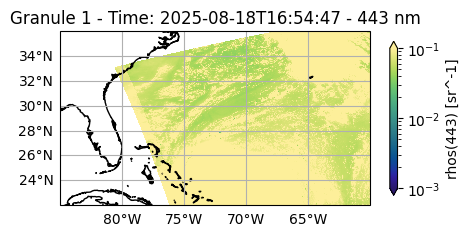

/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:3: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(path)
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:3: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attrib

Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...


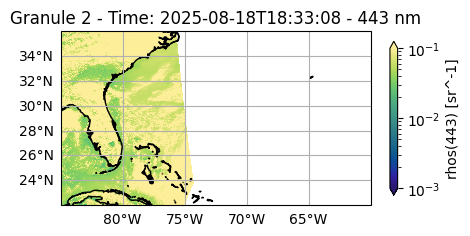

/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:28: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(path)
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:28: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attr

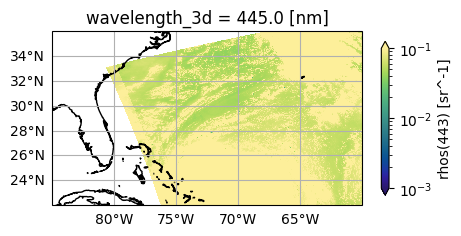

/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:28: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(path)
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/2793842885.py:28: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attr

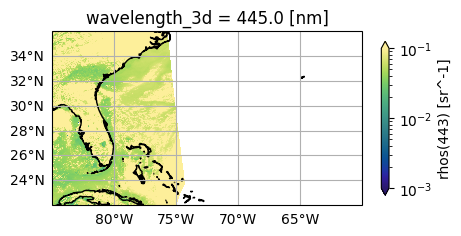

In [50]:
# Add cell to plot unprocessed granules to see what they look like
for i, path in enumerate(pre_paths):
    datatree = xr.open_datatree(path)
    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("longitude", "latitude"))
    print(dataset[var_name].coords)

    var_data = dataset[var_name]
    var_data = var_data.transpose('wavelength_3d', 'number_of_lines', 'pixels_per_line')

    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
    plot = var_data.sel(wavelength_3d=443, method='nearest').plot(
        x="longitude", y="latitude",
        cbar_kwargs={'label': 'rhos(443) [sr^-1]', 'shrink': 0.5},
        cmap=cmocean.cm.haline,
        norm=LogNorm(vmin=.001, vmax=0.1),
        ax=ax,
        robust=True
    )
    ax.set_xlim(bbox[0]-3, bbox[2]+3)
    ax.set_ylim(bbox[1]-3, bbox[3]+3)
    ax.coastlines()
    ax.set_title(f'Granule {i+1} - Time: {str(dataset.attrs["time_coverage_start"])[:19]} - 443 nm')
    plt.show()

for i, path in enumerate(pre_paths):
    datatree = xr.open_datatree(path)
    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("longitude", "latitude"))

    var_data = dataset[var_name]
    var_data = var_data.transpose('wavelength_3d', 'number_of_lines', 'pixels_per_line')
    quick_plot_sref_1band(var_data)

In [51]:
# extract the geospatial characteristics from the first file in paths using 1-line function
# This cell is steps is parts 1, 2a, and 2b from previous workflow. functions clean things up nicely
crs, shape, transform, wl = load_first_SREF(pre_paths[0], var_name)# once set, dont need to rerun for other vars in same suite

/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/150402396.py:118: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(path)
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/150402396.py:118: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attr

Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...


In [52]:
pre_data = coregister_granules_SREF(pre_paths, crs, shape, transform, var_name)

/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62672 instead
  warnings.warn(
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/150402396.py:26: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_10402/150402396.py:26: FutureWarning: In a future version, x

loaded pre event files


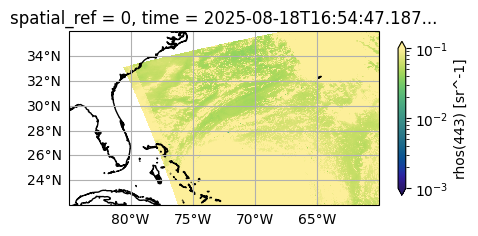

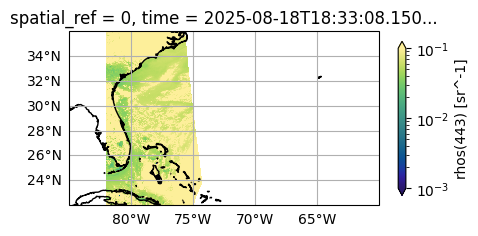

In [53]:
# Now, plot the regridded data to see how it looks at 443 nm
pre_data_2 = pre_data.assign_coords(wavelength_3d=wl)
# for i, data_slice in enumerate(pre_data_2):
#     fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
#     ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
#     plot = data_slice.sel(wavelength_3d=443, method='nearest').plot(
#         x="longitude", y="latitude",
#         cbar_kwargs={'label': 'rhos(443) [sr^-1]', 'shrink': 0.5},
#         cmap=cmocean.cm.haline,
#         norm=LogNorm(vmin=.001, vmax=0.1),
#         ax=ax,
#         robust=True
#     )
#     ax.set_xlim(bbox[0]-3, bbox[2]+3)
#     ax.set_ylim(bbox[1]-3, bbox[3]+3)
#     ax.coastlines()
#     ax.set_title(f'Granule {i+1} - Time: {str(data_slice.time.values)[:19]} - 443 nm')
#     plt.show()

for i, data_slice in enumerate(pre_data_2):
    quick_plot_sref_1band(data_slice)

In [54]:
pre_data_2 = pre_data.assign_coords(wavelength_3d=wl)
rhos_rgb = pre_data_2.sel(wavelength_3d=[645, 555, 445], method="nearest")

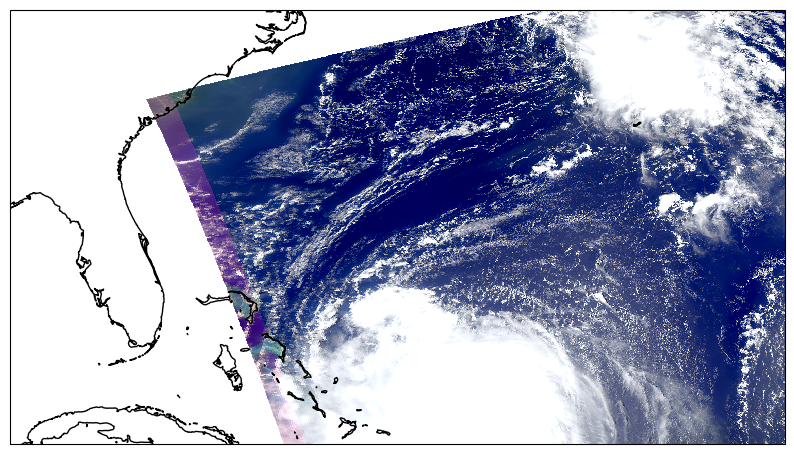

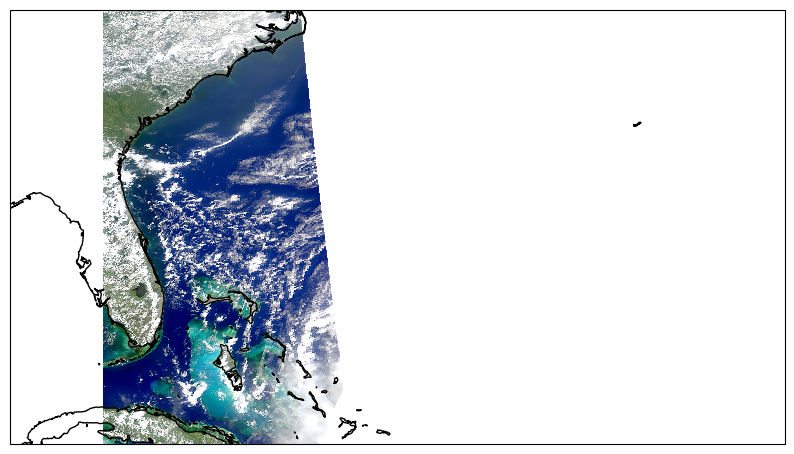

In [55]:
img_array = rhos_rgb.transpose("time", "latitude", "longitude", "wavelength_3d")

for i, data_slice in enumerate(img_array):
    rgb = enhance(data_slice)

    # Mask pixels where all channels are zero (fully black regions)
    zero_mask = (rgb == 0).all(dim="wavelength_3d")
    rgb = rgb.where(~zero_mask)

    fig = plt.figure(figsize=(10, 10))
    axes = plt.subplot(projection=ccrs.PlateCarree())
    artist = axes.pcolormesh(
        rgb["longitude"],
        rgb["latitude"],
        rgb,
        shading="nearest",
        rasterized=True,
        )
    axes.set_aspect("equal")
    axes.set_xlim(bbox[0]-3,bbox[2]+3)
    axes.set_ylim(bbox[1]-3,bbox[3]+3)
    axes.coastlines()
    plt.show()



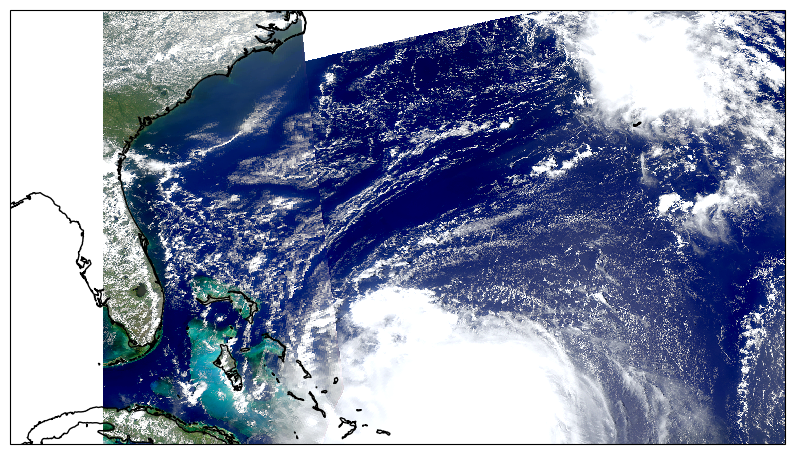

In [58]:
# img_array = rhos_rgb.transpose("time", "latitude", "longitude", "wavelength_3d")
# zero_mask = (img_array == 0).all(dim="wavelength_3d")
# img_array = img_array.where(~zero_mask)
# img_array = img_array.mean("time")

img_array = rhos_rgb.transpose("time", "latitude", "longitude", "wavelength_3d")
zero_mask = (img_array == 0).all(dim="wavelength_3d")
img_array = img_array.where(~zero_mask)
img_array = img_array.ffill("time").isel(time=-1)

rgb = enhance(img_array)

# Mask pixels where all channels are zero (fully black regions)
zero_mask = (rgb == 0).all(dim="wavelength_3d")
rgb = rgb.where(~zero_mask)

fig = plt.figure(figsize=(10, 10))
axes = plt.subplot(projection=ccrs.PlateCarree())
artist = axes.pcolormesh(
    rgb["longitude"],
    rgb["latitude"],
    rgb,
    shading="nearest",
    rasterized=True,
    )
axes.set_aspect("equal")
axes.set_xlim(bbox[0]-3,bbox[2]+3)
axes.set_ylim(bbox[1]-3,bbox[3]+3)
axes.coastlines()
plt.show()

In [ ]:
pre_data

In [ ]:
times = img_array["time"]